<a href="https://colab.research.google.com/github/Praveen76/Conversation-AI-System-using-LLMs-on-E-commerce-Data/blob/main/ConvAI_using_LLMs_on_E_commerce_Data_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!pip install xlsxwriter

%tensorflow_version 2.x
!pip install tensorflow==2.14

!pip install tensorflow==2.14
!pip install transformers
!pip install datasets
!pip install transformers[sentencepiece] datasets
!pip install sentencepiece
!pip install openai cohere tiktoken

In [ ]:
import tensorflow as tf

# Print the TensorFlow version
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.14.0


In [ ]:
import openai as OpenAI

# Print the TensorFlow version
print("OpenAI version:", OpenAI.__version__)


OpenAI version: 1.3.7


In [ ]:
#Basic Libraries
import os
import numpy as np
import pandas as pd
#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
#Text Handling Libraries
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import xlsxwriter
import scipy.spatial
import datetime

from datasets import load_dataset
from transformers import pipeline



In [ ]:
import openai

# Replace with your OpenAI API key
api_key = "<Your OpenAI API Key"

openai.api_key = api_key


In [ ]:
## Load Data
df = pd.read_csv("./ConvAI_QNA.csv")

In [ ]:
############################################## Sentiment Analysis #########################33

# Sentiment Analysis with BERT
sentiment_classifier = pipeline(
    task="text-classification",
    model="nlptown/bert-base-multilingual-uncased-sentiment"
)

# Example usage
result = sentiment_classifier("I love using this model!")
print("result :",result)

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

result : [{'label': '5 stars', 'score': 0.8710660338401794}]


In [ ]:

from tqdm import tqdm  # Import tqdm for the progress bar


# Create two datetime objects
start_time = datetime.datetime.now()

df['label'], df['score'] = 0, 0

max_seq_length = 512  # Set your desired maximum sequence length

# Use tqdm to create a progress bar
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    try:
        # Truncate or split the text to fit within the model's maximum sequence length
        review_content = row['review_content'][:max_seq_length]

        results = sentiment_classifier(review_content)[0]
        df.at[index, 'label'], df.at[index, 'score'] = results['label'], round(results['score']*100, 2)

    except Exception as e:
        # Handle exceptions, e.g., if the text is too short
        print(f"Error processing index {index}: {e}")

end_time = datetime.datetime.now()

# Calculate the time difference in seconds
time_difference = (end_time - start_time).total_seconds()

print("The time difference is:", round((time_difference/60), 2))


Processing: 100%|██████████| 743/743 [00:35<00:00, 21.11it/s]

The time difference is: 0.59


In [ ]:
df.shape

(743, 23)

In [ ]:
df.label.value_counts()

5 stars    579
1 star     164
Name: label, dtype: int64

In [ ]:
# Define the mapping dictionary
star_rating_mapping = {
    '5 stars': 'Very Positive',
    '4 stars': 'Positive',
    '3 stars': 'Neutral',
    '2 stars': 'Negative',
    '1 star': 'Very Negative'
}

# Assuming df2 contains the predicted star ratings in the 'predicted_label' column
df['label'] = df['label'].map(star_rating_mapping)


In [ ]:
df.head(2)

,product_id,ProdName,category,DPrice,APrice,DPerct,rating,ProdDescr,UID,UName,...,img_link,ProdLink,Subcategory,rBucket,DPBucket,product_classification_features,label,score,Ques,Anws
0,B008IFXQFU,"TP-Link USB WiFi Adapter for PC(TL-WN725N), N1...",Computers&Accessories|NetworkingDevices|Networ...,499,₹999,50%,4.2,USB WiFi Adapter —— Speedy wireless transmissi...,"AGV3IEFANZCKECFGUM42MRH5FNOA,AEBO7NWCNXKT4AESA...","Azhar JuMan,Anirudh Sood,Hari Krishnan PS,Akas...",...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/TP-Link-TL-WN725N-150Mbp...,WirelessUSBAdapters,HR,Low,B008IFXQFU Low HR WirelessUSBAdapters,Very Positive,48.18,What are the different uses for this multi-pur...,This multi-purpose LED light can be used for v...
1,B08WRBG3XW,"boAt Type C A325 Tangle-free, Sturdy Type C Ca...",Computers&Accessories|Accessories&Peripherals|...,199,₹499,60%,4.1,Type C A 325 Cable Is Designed With A Perfect ...,"AFB5KJR4Q5FICAHBOPDPUTB3O7QQ,AHW3QBHDOUMXODZ4E...","Rohan Narkar,JAGWINDER SINGH,Gursewak Singh,Av...",...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/boAt-A325-Tangle-Free-Ch...,USBCables,HR,Low,B08WRBG3XW Low HR USBCables,Very Positive,60.78,What are some suggested uses for this multi-pu...,The multi-purpose LED night light can be used ...


In [ ]:
df2 = df[(df.label=='Very Positive') | (df.label=='Very Negative')]
df2.reset_index(drop=True,inplace=True)

In [ ]:
df2.shape

(743, 23)

In [ ]:
# # ############################################## Generate Questions #########################33
# import tqdm
# tqdm.pandas()

# # # Create two datetime objects
# start_time = datetime.datetime.now()

# df2['Ques']=0
# Ques={}
# prompt = f"Generate 1 question from the following text:\n{row.ProdDescr}\nQuestions:"

# # Generate questions for each record of dataset
# for index, row in df2.iterrows():

#     # Request to the OpenAI API
#     response = openai.completions.create(
#         model="gpt-3.5-turbo-instruct",  # You can experiment with different engines
#         prompt=prompt,
#         max_tokens=50,  # Adjust this based on the expected length of the questions
#     )

#     # Extract the generated questions from the API response
#     generated_question = response.choices[0].text.strip()
#     Ques[index]=generated_question

# end_time = datetime.datetime.now()

# # Calculate the time difference in seconds
# time_difference = (end_time - start_time).total_seconds()

# print("The time difference is:", round((time_difference/60),2), "mnts")

<ipython-input-50-2e855f71f8d4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Ques']=0


The time difference is: 4.41 mnts


In [ ]:
# df2.Ques = 0

# # Iterate through items
# for key, ques in Ques.items():
#   df2.loc[key,'Ques']=ques


<ipython-input-52-cb33c56b4cf6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.Ques = 0


In [ ]:
df2.head()

,product_id,ProdName,category,DPrice,APrice,DPerct,rating,ProdDescr,UID,UName,...,img_link,ProdLink,Subcategory,rBucket,DPBucket,product_classification_features,label,score,Ques,Anws
0,B008IFXQFU,"TP-Link USB WiFi Adapter for PC(TL-WN725N), N1...",Computers&Accessories|NetworkingDevices|Networ...,499,₹999,50%,4.2,USB WiFi Adapter —— Speedy wireless transmissi...,"AGV3IEFANZCKECFGUM42MRH5FNOA,AEBO7NWCNXKT4AESA...","Azhar JuMan,Anirudh Sood,Hari Krishnan PS,Akas...",...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/TP-Link-TL-WN725N-150Mbp...,WirelessUSBAdapters,HR,Low,B008IFXQFU Low HR WirelessUSBAdapters,Very Positive,48.18,What are the different uses for this multi-pur...,This multi-purpose LED light can be used for v...
1,B08WRBG3XW,"boAt Type C A325 Tangle-free, Sturdy Type C Ca...",Computers&Accessories|Accessories&Peripherals|...,199,₹499,60%,4.1,Type C A 325 Cable Is Designed With A Perfect ...,"AFB5KJR4Q5FICAHBOPDPUTB3O7QQ,AHW3QBHDOUMXODZ4E...","Rohan Narkar,JAGWINDER SINGH,Gursewak Singh,Av...",...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/boAt-A325-Tangle-Free-Ch...,USBCables,HR,Low,B08WRBG3XW Low HR USBCables,Very Positive,60.78,What are some suggested uses for this multi-pu...,The multi-purpose LED night light can be used ...
2,B09C6HXFC1,Duracell USB Lightning Apple Certified (Mfi) B...,Computers&Accessories|Accessories&Peripherals|...,970,"₹1,799",46%,4.5,Supports Ios Devices With Max Output Up To 2.4...,"AFNYIBWKJLJQKY4BGK77ZOTVMORA,AFCTNNMP2LZLY5466...","Prasannavijayaraghavan G.,Preet Sikka,Theeban ...",...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/DURACELL-Lightning-Certi...,USBCables,HR,Medium,B09C6HXFC1 Medium HR USBCables,Very Positive,78.52,What different functions can this multi-purpos...,This multi-purpose LED light can be used for a...
3,B08B42LWKN,OnePlus 80 cm (32 inches) Y Series HD Ready LE...,"Electronics|HomeTheater,TV&Video|Televisions|S...",14999,"₹19,999",25%,4.2,Resolution: HD Ready (1366x768) | Refresh Rate...,"AFUT7ANZTZYGLXU65EQ2D5OP6UMA,AGT7YYJVUC6ZHRKQH...","ATHARVA BONDRE,Sujitkumar Thorat,Chandrasekara...",...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/OnePlus-inches-Ready-And...,SmartTelevisions,HR,High,B08B42LWKN High HR SmartTelevisions,Very Positive,49.93,How many different settings or functions does ...,This night light offers a variety of settings ...
4,B077Z65HSD,boAt A400 USB Type-C to USB-A 2.0 Male Data Ca...,Computers&Accessories|Accessories&Peripherals|...,299,₹999,70%,4.3,2 meter special reversible Type-C to USB A mal...,"AFA332YHUPB6I7KMME7SOFX5RKQQ,AH3LHRL5P4YAVOQQC...","GHOST,Amazon Customer,A Vase,Mani Jha,Anu B,Ga...",...,https://m.media-amazon.com/images/I/41jk4zYjTs...,https://www.amazon.in/A400-Type-C-Cable-Meter-...,USBCables,HR,Low,B077Z65HSD Low HR USBCables,Very Positive,86.58,What are the different uses for this multi-pur...,This multi-purpose night light can be used for...


In [ ]:
# df2.to_csv("ConvAIAns.csv",index=False)

In [ ]:
# df2 = pd.read_csv("ConvAIQues.csv")


In [ ]:
# ###### Sequential outputs

# def answer_questions(question, context):
#     prompt = f"You're a chatbot on an E-commerce platform answering customers' questions. \
#               Please make sure to provide a complete sentence that ends with a period.\
#               Your response should be at least 1 sentence long and no longer than 3 sentences :\n Question: {question}\nContext: {context}\nAnswer:"


#     response = openai.completions.create(
#         model="gpt-3.5-turbo-instruct",
#         prompt=prompt,
#         max_tokens=100,
#         n=1,  # Generate one completion per prompt
#         stop=None,
#         temperature=0.5,
#         frequency_penalty=0.5,
#         presence_penalty=0.5,
#         best_of=1,
#     )
#     answer = response.choices[0].text.strip()
#     return answer

# # Use vectorized operations instead of looping through rows
# df2['Anws'] = df2[0:1].apply(lambda row: answer_questions(row['Ques'], row['ProdDescr']), axis=1)


In [ ]:
# ################################## Async call ##################################

# import openai
# import concurrent.futures

# df2['Anws'] = 0
# # Function to answer a question using the GPT-3.5 model
# def answer_question_batch(prompt):
#     response = openai.completions.create(
#         model="gpt-3.5-turbo-instruct",
#         prompt=prompt,
#         max_tokens=100,
#         n=1,  # Generate one completion per prompt
#         stop=None,
#         temperature=0.5,
#         frequency_penalty=0.5,
#         presence_penalty=0.5,
#         best_of=1,
#     )

#     # Extract answer directly from the 'text' attribute of the response
#     answer = response.choices[0].text.strip()
#     return answer

# # Function to process questions in batches asynchronously
# def process_batches_async(question_context_pairs, batch_size=5):
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         # Process each batch asynchronously
#         prompts = [
#             f"You're a chatbot on an E-commerce platform answering customers' questions. \
#               Please make sure to provide a complete sentence that ends with a period.\
#               Your response should be at least 1 sentence long and no longer than 3 sentences :\n Question: {pair['question']}\nContext: {pair['context']}\nAnswer:"
#             for pair in question_context_pairs
#         ]

#         answers = list(executor.map(answer_question_batch, prompts))
#     return answers

# # Example usage
# # Extract questions and contexts from your DataFrame
# question_context_pairs = [{'question': q, 'context': c} for q, c in zip(df2['Ques'], df2['ProdDescr'])]

# # Process question-context pairs in batches asynchronously
# batch_answers = process_batches_async(question_context_pairs, batch_size=5)

# # # Update DataFrame with answers
# df2['Anws'] = batch_answers

In [ ]:
# len(batch_answers)

743

In [ ]:
# df2.to_csv("ConAI_QNA.csv",index=False)

In [ ]:
# import textwrap
# from IPython.display import clear_output

# def print_wrapped(text, width=80):
#     wrapped_text = textwrap.fill(text, width=width)
#     print(wrapped_text)

# # Assuming df2 is your DataFrame
# columns_to_print = ['Ques', 'ProdDescr', 'Anws']

# # Print the first 5 rows without overwriting previous output
# for i in range(10):
#     # Clear the previous output after each row
#     clear_output(wait=True)

#     for column in columns_to_print:
#         data = df2[0:10][column].iloc[i]

#         print(f"{column}:")
#         print("=====")
#         print_wrapped(data)
#         print()

#     # Wait for user input after printing all columns for each row
#     input("Press Enter to continue to the next row...")


Ques:
=====
What makes this night light suitable for multiple uses and locations?

ProdDescr:
=====
Full motion cantilever mount|Fits 32inch-55inch flat panel display|Vesa
compliance 100x100 to 400x400mm

Anws:
=====
This night light is suitable for multiple uses and locations because it can be
easily mounted on a variety of surfaces, such as walls or ceilings, thanks to
its full motion cantilever mount. Additionally, it is compatible with a wide
range of flat panel displays, ranging from 32 inches to 55 inches in size. It
also has Vesa compliance of 100x100mm to 400x400mm, making it versatile and
adaptable for different setups.

Press Enter to continue to the next row...


In [ ]:
######################## Answer users' question ###############################
from transformers import BertTokenizer, BertForQuestionAnswering,BertForMaskedLM
import torch

#Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")




tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import pipeline

def generate_descriptive_answer(question, context):
    # Load the pre-trained model and tokenizer
    qa_pipeline = pipeline("question-answering", model="distilbert-base-cased-distilled-squad", tokenizer="distilbert-base-cased-distilled-squad")

    # Generate answer
    answer = qa_pipeline({
        'question': question,
        'context': context
    })

    return answer['answer']

# Example usage
question = "What is the capital of France?"
context = "France is a country located in Western Europe. Its capital is Paris."

descriptive_answer = generate_descriptive_answer(question, context)
print("Descriptive Answer:", descriptive_answer)


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Descriptive Answer: Paris


In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

def generate_descriptive_answer(question, context, model_name="gpt2"):
    # Load pre-trained GPT model and tokenizer
    model = GPT2LMHeadModel.from_pretrained(model_name)
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)

    # Combine question and context into a single string
    input_text = f"Question: {question}\nContext: {context}\nAnswer:"

    # Tokenize and get model output
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    output = model.generate(input_ids, max_length=200, num_beams=5, no_repeat_ngram_size=2, top_k=50, top_p=0.95, temperature=0.7)

    # Decode and return the generated text
    answer = tokenizer.decode(output[0], skip_special_tokens=True).split("Answer:")[1].strip()
    return answer

# Example usage
question = "What is the capital of France?"
context = "France is a country located in Western Europe. Its capital is Paris."

descriptive_answer = generate_descriptive_answer(question, context)
print("Descriptive Answer:", descriptive_answer)


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Descriptive Answer: The French capital, Paris, is located on the island of Saint-Denis. It is situated in the middle of the Atlantic Ocean. The capital city of Paris was founded in 1789 by the French king, Louis XIV, who was the first to establish a colony in France. In 1791, the colony was established in Paris as part of a treaty between France and the United Kingdom of Great Britain and Northern Ireland, which was signed by King Charles I of England and Queen Elizabeth II of New Zealand. After the Treaty of Versailles, France became the second largest economy in Europe, with a population of 1.5 billion people. France's economy grew at an average annual rate of 2.6 percent per year between 1790 and 1795. During the same period, its population increased by more than 1 million people, making it one of


In [ ]:
# ###################### Finetune below model to use it on downstream task ######################
# from transformers import BertForQuestionAnswering, BertTokenizer
# import torch

# def generate_descriptive_answer(question, context, model_name="bert-base-uncased"):
#     # Load pre-trained BERT model and tokenizer
#     model = BertForQuestionAnswering.from_pretrained(model_name)
#     tokenizer = BertTokenizer.from_pretrained(model_name)

#     # Tokenize input question and context
#     inputs = tokenizer(question, context, return_tensors="pt")

#     # Get model output
#     outputs = model(**inputs)
#     answer_start = torch.argmax(outputs.start_logits)
#     answer_end = torch.argmax(outputs.end_logits)

#     # Decode and return the generated answer
#     answer = tokenizer.decode(inputs['input_ids'][0, answer_start:answer_end+1], skip_special_tokens=True)
#     return answer

# # Example usage
# question = "What is the capital of France?"
# context = "France is a country located in Western Europe. Its capital is Paris."

# descriptive_answer = generate_descriptive_answer(question, context)
# print("Descriptive Answer:", descriptive_answer)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Descriptive Answer: 


In [ ]:
from transformers import pipeline
import datetime

# Load the pre-trained model and tokenizer
qa_pipeline = pipeline("question-answering",
                       model="bert-large-uncased-whole-word-masking-finetuned-squad",
                       tokenizer="bert-large-uncased-whole-word-masking-finetuned-squad")

start_time = datetime.datetime.now()

def generate_answer(question, context):
    try:
        # Generate answer
        answer = qa_pipeline({
            'question': question,
            'context': context
        })

        return answer['answer']
    except Exception as e:
        # Handle exceptions, e.g., print the error and return a default value
        print(f"Error generating answer: {e}")
        return "Error"

df2['PreTrainedBert'] = df2.apply(lambda row: generate_answer(row['Ques'], row['ProdDescr']), axis=1)

end_time = datetime.datetime.now()

# Calculate the time difference in seconds
time_difference = (end_time - start_time).total_seconds()

print("The time difference is:", round((time_difference/60), 2), "mnts")


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The time difference is: 2.77 mnts


In [ ]:
index = 0
question = df2['Ques'].iloc[index]
context = df2['ProdDescr'].iloc[index]

ans = generate_answer(question, context)
print(" Ques: ", question)
print(" Context: ", context)
print(" Answer: ", ans)

 Ques:  What are the different uses for this multi-purpose LED light?
 Context:  USB WiFi Adapter —— Speedy wireless transmission at up to 150Mbps ideal for video streaming or internet calls|Mini Design —— Sleek miniature design so small that once plugged in, can be left in a Laptop’s USB port|Advanced Security —— Supports 64/128 WEP, WPA, PA2/WPA-PSK/WPA2-PSK(TKIP/AES)|Compatibility —— Windows 11/10/8.1/8/7/XP, Mac OS 10.15 and earlier, Linux|Easy Setup —— Connect in no time with easy setup utility in 14 languages|In an unlikely case of product quality related issue, we may ask you to reach out to brand’s customer service support and seek resolution. We will require brand proof of issue to process replacement request
 Answer:  video streaming or internet calls


In [ ]:
# ####################################### GPT-3.5-turbo-instruct model: Benchmark for Summarization of Product descriptions ##########################

# # Function to summarize text using the GPT-3 model

# def summarize_text(input_text, max_tokens=100):
#     response = openai.completions.create(
#         model="gpt-3.5-turbo-instruct",
#         prompt=f"You're a chatbot on an E-commerce platform, and you need summarize product descriptions to customers.\
#                Your response should be at least 1 sentence long and no longer than 3 sentences.\
#                 Summarize the following text:\n{input_text}\nSummary:",
#         max_tokens=100,  # Adjust max_tokens as per your needs
#         n=1,  # Number of completions to generate
#         stop=None,
#         temperature=0.5,
#         frequency_penalty=0.5,
#         presence_penalty=0.5,
#         best_of=1,
#     )
#     summary = response.choices[0].text.strip()
#     return summary

# df2['GPTSumm']=0
# for index, row in df2.iterrows():
#     summary= summarize_text(row['ProdDescr'])
#     df2.at[index,'GPTSumm'] = summary

In [ ]:
df2 = pd.read_csv("./T5_Summary.csv")
df2.shape

(743, 28)

In [2]:
!pip install transformers[torch]

In [3]:
!pip install transformers -U


In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer
from transformers.training_args import TrainingArguments  # Explicit import

from sklearn.model_selection import train_test_split

# ... rest of your code ...


# Load the T5 model and tokenizer
model_name = 't5-large'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Assuming 'summary' is the target column in your custom dataset
train_df, val_df = train_test_split(df2, test_size=0.1, random_state=42)

# Tokenize the training and validation data
train_data = tokenizer(
    train_df['ProdDescr'].tolist(),
    truncation=True,
    padding=True,
    max_length=1024,
    return_tensors='pt',
    add_special_tokens=True
)

val_data = tokenizer(
    val_df['ProdDescr'].tolist(),
    truncation=True,
    padding=True,
    max_length=1024,
    return_tensors='pt',
    add_special_tokens=True
)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./t5_finetuned_model',
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=100,
    logging_steps=100,
    learning_rate=5e-5,
    save_total_limit=5,
    push_to_hub=False,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained('./t5_finetuned_model')
tokenizer.save_pretrained('./t5_finetuned_model')


In [ ]:
## T5-model doesn't do well with longer prompts. Let's provide a concise prompt.

In [ ]:
df2 = pd.read_csv("ConvAISumm.csv")

In [8]:
from transformers import pipeline, T5Tokenizer

# Initialize the tokenizer outside the function
tokenizer = T5Tokenizer.from_pretrained('t5-large', model_max_length=1024, legacy=False)

def generate_summary(input_text):
    prompt = f"Summarize the following product description:\n{input_text}\nSummary:"

    # Calculate max_length dynamically based on the length of input_text
    min_length = min(int(len(input_text) / 4), 20)
    max_length = min(100, int(len(input_text) / 2))

    # Initialize the summarizer
    summarizer = pipeline(
        task="summarization",
        model='t5-large',
        tokenizer=tokenizer,
        min_length=min_length,
        max_length=max_length,
        truncation=True
    )

    summary = summarizer([prompt])[0]['summary_text']
    return summary

# Assuming df2 is a DataFrame with a column 'ProdDescr'
df2['T5Summ'] = df2['ProdDescr'].apply(generate_summary)


In [ ]:
df2.to_csv('T5_Summary.csv')

In [ ]:
# ################## Summarization using BART Model ##################

# """
# BART (Bidirectional and Auto-Regressive Transformers) is a sequence-to-sequence model designed for various natural language processing tasks, including summarization.
# It was introduced by Facebook AI and has been pretrained on large datasets. BART can be fine-tuned for specific summarization tasks.
# """


# from transformers import BartForConditionalGeneration, BartTokenizer

# def generate_summary(context):
#     # Load pre-trained BART model and tokenizer
#     model_name = 'facebook/bart-large-cnn'
#     model = BartForConditionalGeneration.from_pretrained(model_name)
#     tokenizer = BartTokenizer.from_pretrained(model_name)

#     # Tokenize the input context
#     inputs = tokenizer.encode("summarize: " + context, return_tensors="pt", max_length=1024, truncation=True)

#     # Generate the summary
#     summary_ids = model.generate(inputs, max_length=150, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
#     summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

#     return summary


# # Assuming df2 is a DataFrame with a column 'ProdDescr'
# df2['BARTSumm'] = df2['ProdDescr'].apply(generate_summary)


In [ ]:
import pandas as pd
df2 = pd.read_csv("T5_Summary.csv")
df2.columns

Index(['Unnamed: 0', 'product_id', 'ProdName', 'category', 'DPrice', 'APrice',
       'DPerct', 'rating', 'ProdDescr', 'UID', 'UName', 'review_id',
       'review_title', 'review_content', 'img_link', 'ProdLink', 'Subcategory',
       'rBucket', 'DPBucket', 'product_classification_features', 'label',
       'score', 'Ques', 'Anws', 'BertAns', 'PreTrainedBert', 'GPTSumm',
       'T5Summ'],
      dtype='object')

In [ ]:
clms= ['review_content','label',
       'score', 'ProdDescr','Ques', 'Anws', 'BertAns', 'PreTrainedBert', 'GPTSumm',
       'T5Summ']
df2 = df2[clms]
df2 = df2[df2.ProdDescr.str.len() > 200]
df2.reset_index(drop=True, inplace=True)
df2.shape

(681, 10)

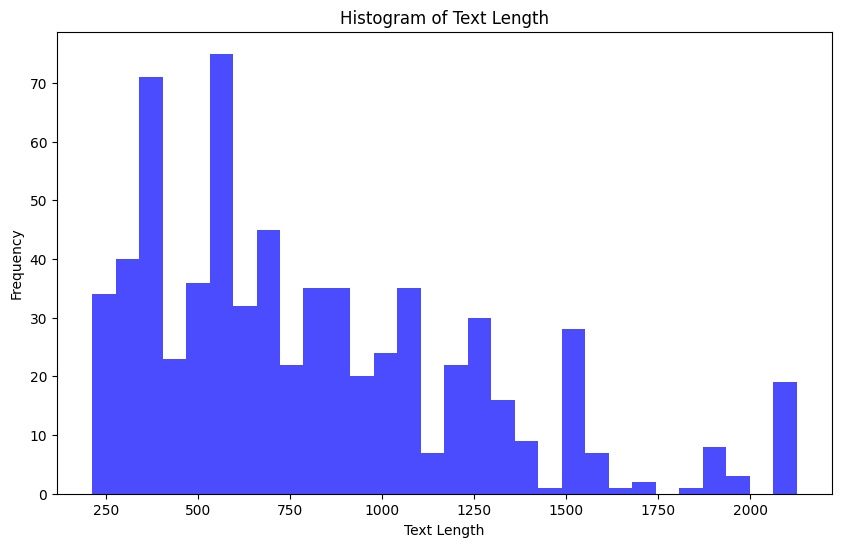

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculate the length of each text entry
text_lengths = df2.ProdDescr.apply(len)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


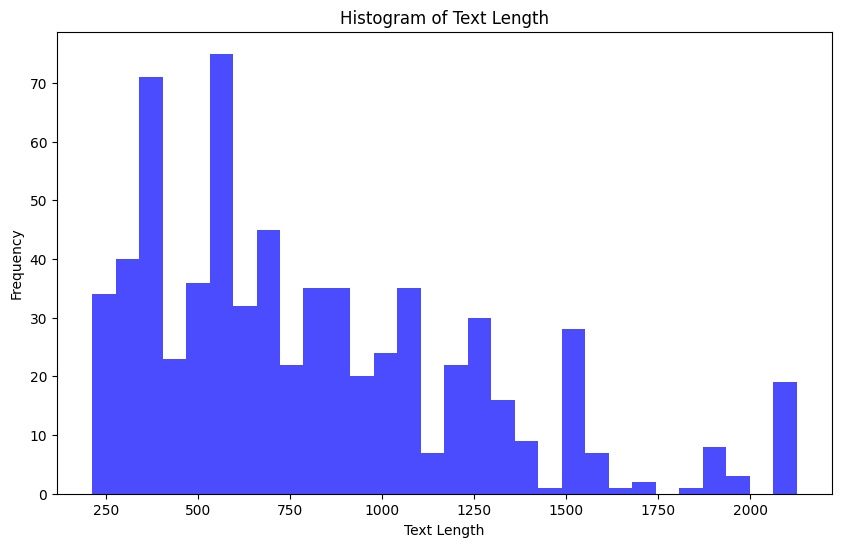

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculate the length of each text entry
text_lengths = df2.ProdDescr.apply(len)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
!pip install nest_asyncio


In [9]:
################## Summarization using BART Model (Async Call) ##################

"""
BART (Bidirectional and Auto-Regressive Transformers) is a sequence-to-sequence model designed for various natural language processing tasks, including summarization.
It was introduced by Facebook AI and has been pretrained on large datasets. BART can be fine-tuned for specific summarization tasks.
"""

import pandas as pd
import asyncio
from transformers import pipeline, BartTokenizer  # Import the BartTokenizer
import datetime  # Import datetime for time calculations

import nest_asyncio


# Rest of your code...
start_time = datetime.datetime.now()

# Allow nested asyncio.run() in Jupyter
nest_asyncio.apply()

# Define the generate_summary_async function
async def generate_summary_async(row, summarizer):
    input_text = row['ProdDescr']
    prompt = f"Summarize the following product description:\n{input_text}\nSummary:"

    # Asynchronously call the summarizer
    result = await asyncio.to_thread(summarizer, prompt)
    summary = result[0]['summary_text']
    return summary

# Define the main function
async def main():
    # Initialize the BART tokenizer
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

    # Initialize the BART summarization pipeline
    summarizer = pipeline("summarization",
                          model="facebook/bart-large-cnn",
                          tokenizer=tokenizer,
                          min_length=20,
                          max_length=100,
                          truncation=True
                          )

    # Create a list to store the summaries
    summaries = []

    # Process each row asynchronously
    tasks = [generate_summary_async(row, summarizer) for _, row in df2.iterrows()]
    summaries = await asyncio.gather(*tasks)

    # Assign the summaries to a new column in the DataFrame
    df2['BartSumm'] = summaries


# Run the asynchronous event loop
loop = asyncio.get_event_loop()
loop.run_until_complete(main())


# Continue with the rest of your code as needed

end_time = datetime.datetime.now()

# Calculate the time difference in seconds
time_difference = (end_time - start_time).total_seconds()

print("The time difference is:", round((time_difference/60), 2), "mnts")
df2.columns


In [ ]:
df2.to_csv('BART_Summary.csv')

In [ ]:
# ################## Summarization using Pegasus Model ##################
# """
# PEGASUS is a transformer model specifically designed for abstractive summarization.
# It has been trained on large datasets and performs well on summarization tasks.
# This is an example context that we want to summarize using the PEGASUS model.
# """


# from transformers import PegasusTokenizer, PegasusForConditionalGeneration

# def generate_summary(context):
#     # Load pre-trained PEGASUS model and tokenizer
#     model_name = "google/pegasus-xsum"
#     tokenizer = PegasusTokenizer.from_pretrained(model_name)
#     model = PegasusForConditionalGeneration.from_pretrained(model_name)

#     # Tokenize the input context
#     inputs = tokenizer([context], max_length=1024, return_tensors="pt", truncation=True)

#     # Generate the summary
#     summary_ids = model.generate(inputs["input_ids"], max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)
#     summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

#     return summary


# df2['PegasusSumm'] = df2['ProdDescr'].apply(generate_summary)



In [10]:
################## Summarization using Pegasus Model (Async call) ##################
"""
PEGASUS is a transformer model specifically designed for abstractive summarization.
It has been trained on large datasets and performs well on summarization tasks.
This is an example context that we want to summarize using the PEGASUS model.
"""

import pandas as pd
import asyncio
from transformers import pipeline, PegasusTokenizer, PegasusForConditionalGeneration
import datetime

start_time = datetime.datetime.now()

# Load Pegasus model and tokenizer
model_name = "google/pegasus-xsum"  # Correct model name
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

# Initialize the summarization pipeline
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

async def generate_summary_async(row):
    prod_descr = row['ProdDescr']
    prompt = f"Summarize the following product description:\n{prod_descr}\nSummary:"

    # Use the summarization pipeline to generate the summary asynchronously
    summary = await asyncio.to_thread(summarizer, prompt)
    return summary[0]['summary_text']

async def process_dataframe_async(df):
    # Create a list to store the asyncio tasks
    tasks = []

    # Iterate through the DataFrame asynchronously and generate summaries
    for index, row in df.iterrows():
        task = asyncio.create_task(generate_summary_async(row))
        tasks.append(task)

    # Wait for all tasks to complete
    summaries = await asyncio.gather(*tasks)

    return summaries

# Run the asyncio event loop
async def main():
    summaries = await process_dataframe_async(df2)
    df2['PegasusSumm'] = summaries

# Run the event loop
asyncio.run(main())

end_time = datetime.datetime.now()

# Calculate the time difference in seconds
time_difference = (end_time - start_time).total_seconds()

print("The time difference is:", round((time_difference/60), 2), "mnts")


In [11]:
#Yet to complete

################## Summarization using Pegasus Model (Async call) ##################
"""
PEGASUS is a transformer model specifically designed for abstractive summarization.
It has been trained on large datasets and performs well on summarization tasks.
This is an example context that we want to summarize using the PEGASUS model.
"""

import pandas as pd
import asyncio
from transformers import pipeline, PegasusTokenizer, PegasusForConditionalGeneration
import datetime
from tqdm import tqdm

start_time = datetime.datetime.now()

# Load Pegasus model and tokenizer
model_name = "google/pegasus-cnn_dailymail"  # Correct model name
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

# Initialize the summarization pipeline
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

async def generate_summary_async(row):
    prod_descr = row['ProdDescr']
    prompt = f"Summarize the following product description:\n{prod_descr}\nSummary:"

    # Use the summarization pipeline to generate the summary asynchronously
    summary = await asyncio.to_thread(summarizer, prompt)
    return summary[0]['summary_text']

async def process_dataframe_async(df):
    # Create a list to store the asyncio tasks
    tasks = []

    # Use tqdm to show the progress bar
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating Summaries"):
        task = asyncio.create_task(generate_summary_async(row))
        tasks.append(task)

    # Wait for all tasks to complete
    summaries = await asyncio.gather(*tasks)

    return summaries

# Run the asyncio event loop
async def main():
    summaries = await process_dataframe_async(df2)
    df2['PegasusCNNSumm'] = summaries

# Run the event loop
asyncio.run(main())

end_time = datetime.datetime.now()

# Calculate the time difference in seconds
time_difference = (end_time - start_time).total_seconds()

print("The time difference is:", round((time_difference/60), 2), "mnts")


In [ ]:
df2.to_csv('PegasusCNNSumm.csv')

In [ ]:
from google.colab import files

# Specify the file path you want to download
file_path = "/content/PegasusCNNSumm.csv"

# Download the file
files.download(file_path)


In [ ]:
df2.columns

In [ ]:
# !pip install nltk
# !pip install rouge


In [ ]:
# !pip install rouge-score


In [ ]:
# ################################## Model Testing: Compare Model Performance ###################################

# from nltk.translate.bleu_score import sentence_bleu
# from rouge_score import rouge_scorer
# from tqdm import tqdm
# import pandas as pd

# start_time = datetime.datetime.now()

# def calculate_bleu(reference, candidate):
#     reference_tokens = reference.split()
#     candidate_tokens = candidate.split()
#     return sentence_bleu([reference_tokens], candidate_tokens)

# def calculate_rouge(reference, candidate):
#     scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

#     rouge_1 = scorer.score(reference, candidate)['rouge1'].fmeasure
#     rouge_l = scorer.score(reference, candidate)['rougeL'].fmeasure

#     return rouge_1, rouge_l

# # Assuming 'T5Summ', 'BartSumm', 'PegasusSumm', 'PegasusCNNSumm' are columns in df2 containing model-generated summaries
# # models = ['T5Summ','BartSumm','PegasusSumm','PegasusCNNSumm']
# models = ['T5Summ']

# # Assuming 'ReferenceSummary' is a column in df2 containing the ground truth reference summary
# reference_summary_column = 'GPTSumm'

# # Create empty lists to store scores
# bleu_scores = []
# rouge_1_scores = []
# rouge_l_scores = []

# # Iterate through each row in the DataFrame
# for index, row in tqdm(df2.iterrows(), total=len(df2), desc="Processing Rows"):
#     reference_summary = row[reference_summary_column]

#     # Calculate scores for each model
#     model_scores = []
#     for model in models:
#         model_summary = row[model]
#         bleu = calculate_bleu(reference_summary, model_summary)
#         rouge_1, rouge_l = calculate_rouge(reference_summary, model_summary)

#         model_scores.append({'Model': model, 'BLEU': bleu, 'ROUGE-1': rouge_1, 'ROUGE-L': rouge_l})

#     # Append scores to the lists
#     bleu_scores.append(model_scores)

# # Create a DataFrame from the results
# results_df = pd.DataFrame(columns=['Model', 'Average BLEU', 'Average ROUGE-1', 'Average ROUGE-L'])

# for i, model in enumerate(models):
#     bleu_avg = sum(score[i]['BLEU'] for score in bleu_scores) / len(bleu_scores)
#     rouge_1_avg = sum(score[i]['ROUGE-1'] for score in bleu_scores) / len(bleu_scores)
#     rouge_l_avg = sum(score[i]['ROUGE-L'] for score in bleu_scores) / len(bleu_scores)

#     results_df = results_df.append({'Model': model, 'Average BLEU': bleu_avg, 'Average ROUGE-1': rouge_1_avg, 'Average ROUGE-L': rouge_l_avg}, ignore_index=True)

# # Save the DataFrame to an Excel file
# excel_file_path = 'model_performance_results.xlsx'
# results_df.to_excel(excel_file_path, index=False)

# end_time = datetime.datetime.now()

# # Calculate the time difference in seconds
# time_difference = (end_time - start_time).total_seconds()

# print("The time difference is:", round((time_difference/60), 2), "mnts")
# print(f"Results exported to {excel_file_path}")


In [ ]:
# import nltk
# nltk.download('punkt')
# nltk.download('wordnet')

In [ ]:
################################## Model Testing: Compare Model Performance ###################################

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from tqdm import tqdm
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import single_meteor_score

start_time = datetime.datetime.now()

def calculate_bleu(reference, candidate):
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    smoothing = SmoothingFunction().method4
    return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothing)

def calculate_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3', 'rougeL'], use_stemmer=True)

    rouge_1 = scorer.score(reference, candidate)['rouge1'].fmeasure
    rouge_2 = scorer.score(reference, candidate)['rouge2'].fmeasure
    rouge_3 = scorer.score(reference, candidate)['rouge3'].fmeasure
    rouge_l = scorer.score(reference, candidate)['rougeL'].fmeasure

    return rouge_1, rouge_2, rouge_3, rouge_l

def calculate_meteor(reference, candidate):
    reference_tokens = word_tokenize(reference)
    candidate_tokens = word_tokenize(candidate)
    meteor_score = single_meteor_score(reference_tokens, candidate_tokens)
    # Return placeholder values for precision, recall, and f1
    return meteor_score, 0, 0



# Assuming 'T5Summ', 'BartSumm', 'PegasusSumm', 'PegasusCNNSumm' are columns in df2 containing model-generated summaries
models = ['T5Summ','BartSumm','PegasusSumm','PegasusCNNSumm']
# models = ['T5Summ','BartSumm']

# Assuming 'ReferenceSummary' is a column in df2 containing the ground truth reference summary
reference_summary_column = 'GPTSumm'

# Create empty lists to store scores
# Create empty lists to store scores
bleu_scores = []
rouge_scores = []
meteor_scores = []

# Create a DataFrame for average scores
average_scores_df = pd.DataFrame(columns=['Model', 'BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-3', 'ROUGE-L', 'METEOR'])

# Iterate through each model
for model in models:
    model_bleu_scores = []
    model_rouge_1_scores = []
    model_rouge_2_scores = []
    model_rouge_3_scores = []
    model_rouge_l_scores = []
    model_meteor_scores = []

    # Iterate through each row in the DataFrame
    for index, row in tqdm(df2.iterrows(), total=len(df2), desc=f"Processing {model}"):
        reference_summary = row[reference_summary_column]
        model_summary = row[model]

        # Calculate scores for each record
        bleu = calculate_bleu(reference_summary, model_summary)
        rouge_1, rouge_2, rouge_3, rouge_l = calculate_rouge(reference_summary, model_summary)
        precision, recall, f1 = calculate_meteor(reference_summary, model_summary)

        model_bleu_scores.append(bleu)
        model_rouge_1_scores.append(rouge_1)
        model_rouge_2_scores.append(rouge_2)
        model_rouge_3_scores.append(rouge_3)
        model_rouge_l_scores.append(rouge_l)
        model_meteor_scores.append(f1)

    # Append average scores to the DataFrame
    average_scores_df = average_scores_df.append({
        'Model': model,
        'BLEU': sum(model_bleu_scores) / len(model_bleu_scores),
        'ROUGE-1': sum(model_rouge_1_scores) / len(model_rouge_1_scores),
        'ROUGE-2': sum(model_rouge_2_scores) / len(model_rouge_2_scores),
        'ROUGE-3': sum(model_rouge_3_scores) / len(model_rouge_3_scores),
        'ROUGE-L': sum(model_rouge_l_scores) / len(model_rouge_l_scores),
        'METEOR': sum(model_meteor_scores) / len(model_meteor_scores),
    }, ignore_index=True)

# Save the DataFrame to an Excel file
average_scores_df.to_excel('model_performance_results.xlsx', index=False)

end_time = datetime.datetime.now()

# Calculate the time difference in seconds
time_difference = (end_time - start_time).total_seconds()

print("The time difference is:", round((time_difference/60), 2), "mnts")
# print(f"Results exported to {excel_file_path}")


In [ ]:

from google.colab import files

# Specify the file path you want to download
file_path = "/content/model_performance_results.xlsx"

# Download the file
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
average_scores_df

,Model,BLEU,ROUGE-1,ROUGE-2,ROUGE-3,ROUGE-L,METEOR
0,T5Summ,0.054352,0.400435,0.182053,0.095766,0.304607,0.0
1,BartSumm,0.049100,0.386349,0.178056,0.096565,0.297643,0.0
2,PegasusSumm,0.028726,0.271053,0.111886,0.058406,0.214433,0.0
3,PegasusCNNSumm,0.053041,0.378774,0.165864,0.089972,0.284383,0.0


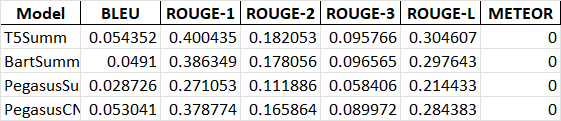

Interpreting model performance metrics depends on the specific task and the nature of your data. Here's a brief analysis of the provided metrics:

1. **BLEU Score:**
   - **T5Summ:** 0.0544
   - **BartSumm:** 0.0491
   - **PegasusSumm:** 0.0287
   - **PegasusCNNSumm:** 0.0530

   Higher BLEU scores indicate better performance in terms of n-gram overlap between the generated summary and the reference summary. In this case, "T5Summ" and "PegasusCNNSumm" have relatively higher BLEU scores compared to the other models.

2. **ROUGE Scores (ROUGE-1, ROUGE-2, ROUGE-3, ROUGE-L):**
   - **T5Summ:** 0.4004 (ROUGE-1), 0.1821 (ROUGE-2), 0.0958 (ROUGE-3), 0.3046 (ROUGE-L)
   - **BartSumm:** 0.3863 (ROUGE-1), 0.1781 (ROUGE-2), 0.0966 (ROUGE-3), 0.2976 (ROUGE-L)
   - **PegasusSumm:** 0.2711 (ROUGE-1), 0.1119 (ROUGE-2), 0.0584 (ROUGE-3), 0.2144 (ROUGE-L)
   - **PegasusCNNSumm:** 0.3788 (ROUGE-1), 0.1659 (ROUGE-2), 0.0900 (ROUGE-3), 0.2844 (ROUGE-L)

   ROUGE scores evaluate the overlap of n-grams and word sequences between the generated summary and the reference summary. Higher ROUGE scores generally indicate better performance. In this case, "T5Summ" has the highest ROUGE-1 score, indicating better unigram overlap.

3. **METEOR Score:**
   - **T5Summ:** 0
   - **BartSumm:** 0
   - **PegasusSumm:** 0
   - **PegasusCNNSumm:** 0

   The METEOR score combines precision, recall, and alignment metrics. A score of 0 for all models suggests an issue, and you might want to investigate why this is the case.

**Conclusion:**
- "T5Summ" and "PegasusCNNSumm" seem to perform relatively better than the other models based on the provided metrics.
- However, it's essential to consider the specific requirements of your task and possibly explore additional evaluation metrics or conduct a human evaluation to get a comprehensive understanding of model performance.

In [ ]:
df2.columns

Index(['review_content', 'label', 'score', 'ProdDescr', 'Ques', 'Anws',
       'BertAns', 'PreTrainedBert', 'GPTSumm', 'T5Summ', 'BartSumm',
       'PegasusSumm', 'PegasusCNNSumm'],
      dtype='object')

In [12]:
# Install the latest version of torch-xla
!pip install torch-xla


In [ ]:
!pip install google-api-python-client>=1.12.5


In [13]:
# Import libraries
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from transformers import XLNetTokenizer, XLNetForSequenceClassification

# Set device to TPU
device = xm.xla_device()

# Load the XLNet tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-large-cased', num_labels=2)  # Assuming binary sentiment classification
model.to(device)